# Рынок заведений общественного питания Москвы

Описание проекта

**Входные данные:** Есть идея открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Требуюется обратиться к инвесторам. 

**Задача:**
Необходимо подготовить исследование рынка по открытым данным о заведениях общественного питания в Москве с целью заинтересовать инвесторов.  Их интересует текущее положение дел на рынке — сможет ли кафе снискать популярность на долгое время, когда все насмотрятся на роботов-официантов.

## Загрузка данных и подготовка их к анализу

Загрузите данные о заведениях общественного питания Москвы. Убедитесь, что тип данных в каждой колонке — правильный, а также отсутствуют пропущенные значения и дубликаты. При необходимости обработайте их.
Путь к файлу: /datasets/rest_data.csv. Скачать датасет

**Описание данных.** 
Таблица rest_data:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

In [1]:
import pandas as pd # загружаем необходимые библиотеки
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
import requests

#### Воспользуемся внешней информацией

 Загрузим данные из файла, хранящегося на Google Таблицах. Это необходимо, чтобы узнать, в каких районах Москвы находятся улицы.

In [2]:
spreadsheet_id = '17_w0IPOXBxnTGNPzGOvwfvhhHoGLKQJo5z91u-_KGlw'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

streets = pd.read_csv(BytesIO(r.content))
streets.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [3]:
streets.columns = ['street_name', 'area_id', 'okrug', 'area']  # изменили названия столбцов согласно правилам хорошего тона

Загрузим данные из файла.

In [4]:
rest_data = pd.read_csv('rest_data.csv')   # переносим данные из файла в датафрейм
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
(rest_data.
 sort_values(by='object_name').
 head(10)
)

,id,object_name,chain,object_type,address,number
7170,28685,1-ЫЙ МОСКОВСКИЙ КАДЕТСКИЙ КОРПУС,нет,столовая,"город Москва, улица Вучетича, дом 30",260
1095,84529,1-й МОК,нет,столовая,"город Москва, Стартовая улица, дом 1, корпус 1",100
14879,213667,100 личная столовая,нет,столовая,"город Москва, Новодмитровская улица, дом 2, ко...",30
14878,213840,100 личное кафе,нет,кафе,"город Москва, Новодмитровская улица, дом 2, ко...",45
1517,24520,1001 ночь,нет,ресторан,"город Москва, Братиславская улица, дом 31, кор...",70
10076,171749,100лоФФка,нет,столовая,"город Москва, Варшавское шоссе, дом 132, строе...",36
11755,188886,101 вкус,нет,кафе,"город Москва, поселение Щаповское, деревня Тро...",16
14239,211469,13 RULES,нет,бар,"город Москва, Люблинская улица, дом 165, корпус 1",15
13787,218120,13 RULES KRAFT BEER,нет,бар,"город Москва, Артековская улица, дом 1",12
12294,199956,13 Rules,нет,бар,"город Москва, Волховский переулок, дом 2",24


Пропущенных значений нет. Наименования столбцов соответствуют стилю.

Проверим дубликаты. 

In [6]:
print('Количество дубликатов в таблице:', rest_data.duplicated().sum())

Количество дубликатов в таблице: 0


При таком подходе дубликатов нет. 

Теперь проверим, какие значения есть в столбце chain (сетевой - не сетевой).

In [7]:
print('Уникальные значения столбца chain:', rest_data['chain'].unique())

Уникальные значения столбца chain: ['нет' 'да']


Значений всего два, пропусков нет - всё правильно на первый взгляд.

Посмотрим, есть ли смысл проверять правильность заполнения флага "сетевой - не сетевой".

Создадим новый столбец с уникальными названиями, для чего приведем буквы названия к нижнему регистру, а также удалим все кавычки, пробелы и слова типа "кафе" или "ресторан".

In [8]:
rest_data['name_str'] = rest_data['object_name'].str.lower()    # привели к строчным

for name in ['«', '»', '"', '-', 'пицца', 'пиццерия', 'кафе', 'кофейня', 'ресторан',
             'предприятие', 'быстрого', 'питания', 'обслуживания', 'столовая', 
             'кухни', 'японской', 'японский', 'лаундж', 'закусочная', 'паб', 'кофе',
             'чешская', 'пивная', 'бар', 'семейное', 'семейный', 'детское', 'детский', ' ']:
    rest_data['name_str'] = rest_data['name_str'].str.replace(name, '')                        # Заменили на ""
    
print('Всего уникальных названий до:', len(rest_data['object_name'].unique()))
print('Всего уникальных названий после:', len(rest_data['name_str'].unique()))

Всего уникальных названий до: 10393
Всего уникальных названий после: 8968


Проверим, нет ли ошибок в определении сетевых ресторанов. Если название одно, а флаг 'chain' = 'да', то, возможно, это ошибка, и тогда ресторан считать сетевым не будем. Сначала создадим список ресторанов с получившимися уникальными названиями и их количеством (методом groupby). Потом отберем те, у которых получившееся количество равно 1.

In [9]:
fault_rest = (rest_data.
              query('chain == "да"').
              groupby('name_str').
              agg({'object_type': 'count'}).
              reset_index().
              rename(columns={'object_type': 'object_count'})
             )
fault_rest_1 = fault_rest[fault_rest['object_count'] == 1].reset_index()['name_str'].to_list()
print('Общее количество', len(fault_rest_1))
print(fault_rest_1)

Общее количество 197
['', 'beverlyhillsdiner', 'bierloga', 'black&white', 'boobo', 'bubbleology', 'coffeeshop', 'cookhouse', 'delibyprimeпрайм', 'fridays', 'fridayskfc', 'goodmanгудман', 'grandcru', 'grandурюк', 'ilfornoильфорно', 'kfcволгоградский', 'makimaki', 'marmalato', 'marrakeshхинкальная', 'mcafeхинкальная', 'movenpick', 'pandaexpress', 'pizengof99спб', 'pomodoroисушидзен', 'prime(праймстар)', 'primestarпраймстар', 'starbucks,старбакс', 'starbuckscoffee', 'starbucksстарбакс', 'tajjmahal', 'theterrace', 'tokyobay', 'torrogrillторрогриль', 'travelerscoffe', 'tuttifrutti', 'upsidedown', 'vietcafeвьет', 'whiterabbite(белыйкролик)', 'авдейлиазбукавкуса', 'акат', 'алло2', 'американсити', 'американситицехпоизготовлениюпиццы', 'антикальяннаяmoskalyan', 'ариана', 'бабайклаб', 'баскинроббинс&стардогс', 'ббэндбургерсв&вбургер', 'билла', 'бистропронто', 'бодрыйденьссобой', 'боулингкосмик', 'бравакоста', 'братьякараваевых', 'бутчербизон', 'в&вбургер', 'вlackburgerчайхона№1', 'ванвок', 'васа

In [10]:
display(rest_data.query('name_str == ""').head())     # Это просто столовая, кафе и т.п.

,id,object_name,chain,object_type,address,number,name_str
20,21950,Кафе,нет,кафе,"город Москва, Алтайская улица, дом 33/7",30,
61,21214,Столовая,нет,столовая,"город Москва, Бабаевская улица, дом 3",90,
238,27703,Кафе,нет,столовая,"город Москва, улица Бориса Галушкина, дом 26",45,
347,130124,Кафе,нет,кафе,"город Москва, улица Дыбенко, дом 44",40,
361,25493,Кафе-пиццерия,нет,ресторан,"город Москва, Заревый проезд, дом 12",200,


Получившееся количество (197 шт) составляет порядка 1,3% от общего количества строк в таблице. При этом мы не можем утверждать, что, например, "Якитория и Спорт" и "Якитория и Ян Примус" не относятся к одной сети. А "Пекарея Волконский" попала в уникальные названия, очевидно, просто из-за опечатки. А также сеть может иметь одно заведение в указанном городе и еще несколько за его пределами. Поэтому ошибкой установленные значения "сетевой" не считаем. Ввиду небольшого процента заменять данные не будем.

Посмотрим, получили ли дубликаты после приведения названий к строчному виду и дальнейшей работы с ними для выявления ошибочных названий.  Проведем отбор, считая дубликатами только тогда, когда совпадают наше строчное название, адрес, количество посадочных мест.

In [11]:
print('Количество дубликатов в таблице:', 
      rest_data.
      duplicated(subset=['name_str', 'address', 'number']).     # отбор 
      sum()
     )

Количество дубликатов в таблице: 104


Посмотрим, что получили.

In [12]:
display(
    rest_data
        [rest_data.
             duplicated(
                 subset=['name_str', 'address', 'number'], 
                 keep=False     # выведем все строчки
             )
        ].
    sort_values(by='address').
    tail(10)
)

,id,object_name,chain,object_type,address,number,name_str
3397,71896,Буфет «Коникс-школьник»,нет,буфет,"город Москва, улица Удальцова, дом 21",100,буфеткониксшкольник
3396,19814,Буфет «Коникс-Школьник»,нет,буфет,"город Москва, улица Удальцова, дом 21",100,буфеткониксшкольник
6420,19756,БАР,нет,бар,"город Москва, улица Улофа Пальме, дом 5, строе...",10,
6423,19759,БАР,нет,бар,"город Москва, улица Улофа Пальме, дом 5, строе...",10,
3721,21049,Бар,нет,бар,"город Москва, улица Фабрициуса, дом 41",20,
3722,126244,Кафе,нет,кафе,"город Москва, улица Фабрициуса, дом 41",20,
2160,21395,Столовая ГБОУ СОШ №1571,нет,буфет,"город Москва, улица Фомичёвой, дом 5",80,гбоусош№1571
2159,21394,Столовая ГБОУ СОШ № 1571,нет,буфет,"город Москва, улица Фомичёвой, дом 5",80,гбоусош№1571
10510,173865,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, улица Черняховского, дом 4А",0,шаурма
10137,172648,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, улица Черняховского, дом 4А",0,шаурма


Мы правы, дубликаты можно удалить.

In [13]:
rest_data = rest_data.drop_duplicates(subset=['name_str', 'address', 'number']).reset_index()
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15262 entries, 0 to 15261
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        15262 non-null  int64 
 1   id           15262 non-null  int64 
 2   object_name  15262 non-null  object
 3   chain        15262 non-null  object
 4   object_type  15262 non-null  object
 5   address      15262 non-null  object
 6   number       15262 non-null  int64 
 7   name_str     15262 non-null  object
dtypes: int64(3), object(5)
memory usage: 954.0+ KB


## Анализ данных

### Соотношение видов объектов общественного питания по количеству

Построим график, создав сводную таблицу.

In [14]:
report = (
    rest_data.
    pivot_table   # Создадим сводную таблицу
    (
        index='object_type', 
        columns='chain',   
        values='id',       #  посчитаем по столбцу id
        aggfunc='nunique'  #  количество уникальных значений
    )
)
report['total'] = report['да'] + report['нет']   # найдем общее число заведений
report = (
    report.
    sort_values   # отсортируем
    (
        by='total', 
        ascending=False  #  по убыванию
    )
)
display(report) # Посмотрим на данные

chain,да,нет,total
object_type,,,
кафе,1395,4666,6061
столовая,3,2580,2583
ресторан,543,1737,2280
предприятие быстрого обслуживания,788,1108,1896
бар,37,817,854
буфет,10,564,574
кафетерий,52,343,395
закусочная,56,290,346
магазин (отдел кулинарии),78,195,273


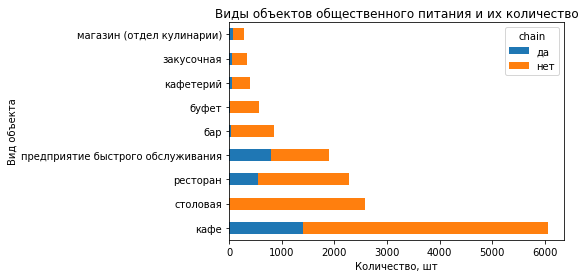

In [15]:
(report[['да', 'нет']].
 plot(                  # строим график:
    kind='barh',        # горизонтальная столбчатая диаграмма
    stacked=True        # на одном столбике оба вида объектов - сетевые и не сетевые ('да', 'нет')
     )   
)

plt.title('Виды объектов общественного питания и их количество') 
plt.xlabel('Количество, шт')
plt.ylabel('Вид объекта')

plt.show()

### Соотношение сетевых и несетевых заведений по количеству

Построим график.

In [16]:
report = (
    rest_data.
    pivot_table   # Создадим сводную таблицу
    (
        index='chain', 
        columns='object_type',   
        values='id',       #  посчитаем по столбцу id
        aggfunc='nunique'  #  количество уникальных значений
    )
)

display(report) # Посмотрим на данные

object_type,бар,буфет,закусочная,кафе,кафетерий,магазин (отдел кулинарии),предприятие быстрого обслуживания,ресторан,столовая
chain,,,,,,,,,
да,37,10,56,1395,52,78,788,543,3
нет,817,564,290,4666,343,195,1108,1737,2580


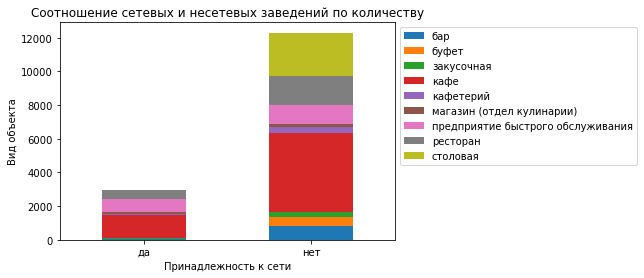

In [17]:
(report.
 plot(
    kind='bar',  #  столбчатая диаграмма
    stacked=True, # все в одном столбике
    rot=0    # повернули подписи
 )
) 


plt.title('Соотношение сетевых и несетевых заведений по количеству') 
plt.xlabel('Принадлежность к сети')
plt.ylabel('Вид объекта')
plt.legend(bbox_to_anchor=(1, 1))  # Сдвинули легенду
plt.show()

### Промежуточные выводы. 

Ответим на вопрос, для какого вида объекта общественного питания характерно сетевое распространение.

По данным двум графикам можем сделать следующие выводы.

По общему количеству:
- больше всего кафе, их количество более чем в два раза превышает число следующей тройки лидеров: столовых, ресторанов или предприятий быстрого обслуживания;
- самые малочисленные - это магазины (отделы кулинарии), закусочные, кафетерии, чуть больше буфетов и баров.

По видам:
- столовые и буфеты сетевыми практически не бывают; 
- больше всего доля сетевых заведений среди кафе, предприятий быстрого обслуживания и ресторанов.

Итак, сетевое распространение характерно для следующих объектов общественного питания: кафе, предприятий быстрого обслуживания и ресторанов, при этом доля сетевых заведений среди общего числа для кафе и ресторанов составляет порядка 25%, а для предприятий быстрого обслуживания - около 40%.


### Соотношение числа заведений в сети и количества посадочных мест

Отразим в переменной sets все сетевые заведения, отвечающие нашим запросам, а именно: в сети должно быть больше 1 заведения, и мы не рассматриваем крайние значения по объему сети или по количеству мест, так как наша первоначальная задача - открыть кафе, а не гиперсеть, поэтому для анализа уберем все максимальные крайние значения (выбросы).

In [18]:
sets = (rest_data.
        query('name_str != ""').                # '' - это безымянные кафе, столовые и т.п., их не учитываем
        sort_values(by=['name_str']).
        groupby('name_str').                    # сгруппировали по имени
        agg({'number': ['count', 'mean']}).     # нашли число заведений и среднее кол-во посадочных мест
        reset_index()
        )

sets.columns = ['name', 'all_count', 'mean_number']

perc_all_count = np.percentile(sets['all_count'], 99)         # граница выбросов - 99-й перцентиль
perc_mean_number = np.percentile(sets['mean_number'], 99)     # граница выбросов


sets = (sets.query('all_count > 1').                    # убрали "сетевые" с 1 заведением
             query('all_count < @perc_all_count').      # убрали выбросы по общему количеству
             query('mean_number < @perc_mean_number')   #  и выбросы по кол-ву посадочных мест
       )

In [19]:
pd.set_option('display.float_format', '{:.0f}'.format)  # Все числа в таблице отражаются с 0 знаков после запятой

sets.describe()                                         # посмотрим данные о квартилях и min, max, средних значениях

,all_count,mean_number
count,1163,1163
mean,3,62
std,1,60
min,2,0
25%,2,18
50%,2,44
75%,3,81
max,9,288


Можно на основе этих данных считать, что "большое количество" заведений - это количество, большее, чем третий квартиль. Аналогично с количеством посадочных мест.

Проанализируем по отдельности 4 вида сетевых заведений, разбитых по принципу "большое/малое количество, много/мало посадочных мест". 

In [20]:
mark_count = np.percentile(sets['all_count'], 75)  # Нашли третий квартиль
mark_number = np.percentile(sets['mean_number'], 75)  

print('Много ресторанов - больше', round(mark_count))
print('Много посадочных мест - больше', round(mark_number))

def categories(df):   # определили функцию для категоризации
    
    if (df['all_count'] <= mark_count):        # условие - малое кол-во 
        if df['mean_number'] <= mark_number:       #  условие - мало посад. мест
            return 'мало - мало мест'
        else:
            return 'мало - много мест'  
    else:                                      # иначе - большое кол-во
        if df['mean_number'] <= mark_number:       #  условие - мало посад. мест
            return 'много - мало мест'
        else:
            return 'много - много мест'


sets['category'] = sets.apply(categories, axis=1)

Много ресторанов - больше 3
Много посадочных мест - больше 81


Зададим свой цвет в зависимости от присвоенной категории и построим точечный график.

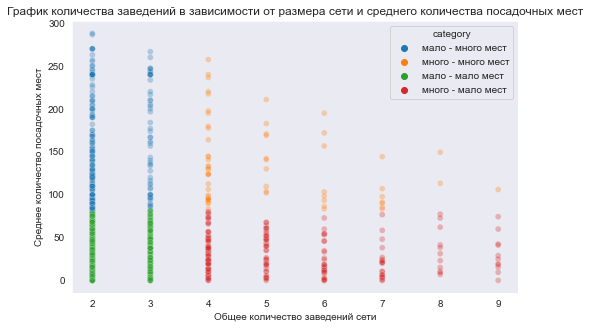

In [21]:
sns.set_style('dark')
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data = sets, 
    x = 'all_count', 
    y = 'mean_number', 
    hue ='category',      # дополнительно раскрасим в зависимости от категории
    alpha = 0.3           #  прозрачность
)

plt.title('График количества заведений в зависимости от размера сети и среднего количества посадочных мест') 
plt.xlabel('Общее количество заведений сети')
plt.ylabel('Среднее количество посадочных мест')
plt.show()

Вывод: у сетевых заведений чем больше объем сети, тем меньше в ней в среднем посадочных мест. Большим заведением можно считать то, в котором больше 80 мест, а большинство сетей имеют 2-3 заведения.

### Среднее количество посадочных мест в зависимости от вида объекта общественного питания

In [22]:
report = (
    rest_data.
    pivot_table                # Создадим сводную таблицу
    (
        index='object_type', 
        values='number',       #  посчитаем по столбцу посадочных мест
        aggfunc='median'       #  медиана  
    ).
    sort_values(by='number', ascending = False)
)


display(report) # Посмотрим на данные

,number
object_type,
столовая,103
ресторан,80
бар,35
буфет,32
кафе,31
кафетерий,6
предприятие быстрого обслуживания,6
закусочная,0
магазин (отдел кулинарии),0


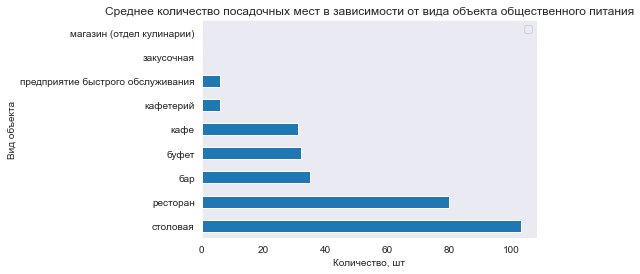

In [23]:
report.plot(kind='barh') #  столбчатая диаграмма
    
plt.title('Cреднее количество посадочных мест в зависимости от вида объекта общественного питания') 
plt.xlabel('Количество, шт')
plt.ylabel('Вид объекта')
plt.legend('')
plt.show()

Самое большое количество посадочных мест предоставляется столовыми, затем ресторанами. Наименьшее число посадочных мест у предприятий быстрого обслуживания и кафетериев. Отделы кулинарии и закусочные посадочные места в основном не предоставляют (нулевые медианные значения), по-видимому, стоячие столики не считаются за посадочное место.


### Топ-10 улиц по количеству объектов общественного питания

 #### Выделим информацию об улице из столбца address. 

In [24]:
rest_data['street_name'] = (
    rest_data['address'].
    apply(                             # применим lambda-функцию
        lambda x: x.split(',')         # разбиваем столбец на список, по разделителю ','
        [1]                            # берем второй элемент (индекс [1]) получившегося списка 
          )                            # (первый - город Москва, третий - дом и тд) 
)

rest_data['street_name'] = rest_data['street_name'].str.strip()  # убрали пробелы с концов строки

rest_data.head()

,index,id,object_name,chain,object_type,address,number,name_str,street_name
0,0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,академия,Абельмановская улица
3,3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица
4,4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,вишневаяметель,Абрамцевская улица


In [25]:
top_street = (
    rest_data.
    pivot_table                                  # Создадим сводную таблицу
    (
        index='street_name',                     # по названию улицы
        values='id',                             #  посчитаем по id
        aggfunc='count'                          #  общее количество
    ).
    sort_values(by='id', ascending = False).     # отсортировали по убыванию кол-ва
    rename(columns={'id': 'number_restaurants'}).
    head(10)                                     #  взяли первые десять
)


display(top_street)                              # Посмотрим на данные

,number_restaurants
street_name,
город Зеленоград,232
проспект Мира,203
Профсоюзная улица,181
Ленинградский проспект,170
Пресненская набережная,167
Варшавское шоссе,161
Ленинский проспект,146
поселение Сосенское,137
проспект Вернадского,128


В список попали город Зеленоград и поселение Сосенское. Для них придется посмотреть данные дополнительно.

In [26]:
display(rest_data.query('street_name == "город Зеленоград"').head())

,index,id,object_name,chain,object_type,address,number,name_str,street_name
1385,1386,22331,СТОЛОВАЯ МИЭТ,нет,столовая,"город Москва, город Зеленоград, улица Юности, ...",56,миэт,город Зеленоград
1404,1405,20199,ЭТО,нет,кафе,"город Москва, город Зеленоград, корпус 401",35,это,город Зеленоград
1405,1406,68113,Френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34,френдс,город Зеленоград
1406,1407,20105,Кафе «Граф Монте-Кристо»,нет,кафе,"город Москва, город Зеленоград, корпус 436",40,графмонтекристо,город Зеленоград
1407,1408,22982,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",49,альфорно,город Зеленоград


Видим, что названия улицы нет, то есть "город Зеленоград" выступает как микрорайон. 

Поселение Сoсенское — внутригородское муниципальное образование со статусом поселения в составе Москвы. Проживает 33 тысячи человек, так же считаем микрорайоном.

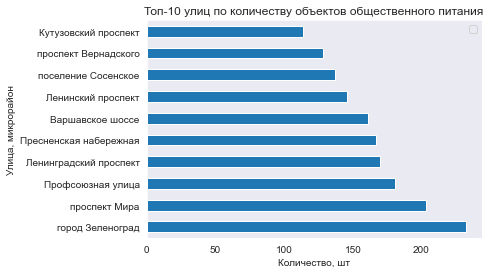

In [27]:
top_street.plot(kind='barh') #  столбчатая диаграмма
    
plt.title('Топ-10 улиц по количеству объектов общественного питания') 
plt.xlabel('Количество, шт')
plt.ylabel('Улица, микрорайон')
plt.legend('')
plt.show()

Возвращаемся к внешней информации (данным из файла, хранящегося на Google Таблицах).
Узнаем, в каких районах Москвы находятся улицы.

In [28]:

top_street_area = (              #  новая переменная top-10 с районами
    top_street.
    reset_index().                                          # добавили индексы
    merge(                                                  # объединяем таблицы
        streets.
        drop(columns = ['area_id', 'okrug'], axis = 1),     # удалив лишние столбцы
        on='street_name',                                   # по названию улицы
        how='left'
    )
)
top_street_area 

,street_name,number_restaurants,area
0,город Зеленоград,232,Район Крюково
1,город Зеленоград,232,Район Матушкино-Савелки
2,город Зеленоград,232,Панфиловский район
3,проспект Мира,203,Алексеевский район
4,проспект Мира,203,Ярославский Район
5,проспект Мира,203,Район Марьина роща
6,проспект Мира,203,Останкинский район
7,проспект Мира,203,Район Ростокино
8,проспект Мира,203,Район Свиблово
9,проспект Мира,203,Мещанский район


Как видим, все эти улицы находятся в нескольких районах, что может говорить о том, что они имеют большую протяженность.

Не найденное во внешних источниках поселение Сoсенское, как уже отмечалось, это внутригородское муниципальное образование со статусом поселения, так что его район - это и есть поселение Сoсенское.

Более подробное изучение данных улиц дает информацию, что большинство из них - это крупные радиальные проспекты, начинающиеся от Садового кольца или ТТК и заканчивающиеся возле МКАД или проходящие дальше. 

Исключение составляет Пресненская набережная, небольшая по протяженности улица, возле которой расположен Московский международный деловой центр «Москва-Сити» с его комплексом небоскребов. Большая плотность ресторанов объясняется именно этим фактором.

### Улицы с одним объектом общественного питания

In [29]:
tail_street_1 = (
    rest_data.
    pivot_table                  #  Создадим сводную таблицу
    (
        index='street_name',     #  по названию улицы
        values='id',             #  посчитаем по id
        aggfunc='count'          #  общее количество
    ).
    rename(columns={'id': 'number_restaurants'})
    
)
tail_street_1 = tail_street_1.query('number_restaurants == 1')

tail_street_1.sample(5)          # Посмотрим на данные - 5 произвольных строк

,number_restaurants
street_name,
Библиотечная улица,1
Воротниковский переулок,1
улица Академика Опарина,1
Платовская улица,1
1-й Курьяновский проезд,1


In [30]:
 
tail_street_1_area = (       #  новая переменная top-10 с районами
    tail_street_1.
    reset_index().                                              # добавили индексы
    merge(                                                      # объединяем таблицы
        streets.drop(columns = ['area_id', 'okrug'], axis = 1), # удалив лишние столбцы
        on='street_name',                                       # по названию улицы
        how='left')
)
tail_street_1_area.head()


,street_name,number_restaurants,area
0,1-й Балтийский переулок,1,Район Аэропорт
1,1-й Басманный переулок,1,Басманный район
2,1-й Басманный переулок,1,Красносельский район
3,1-й Ботанический проезд,1,Район Свиблово
4,1-й Вешняковский проезд,1,Рязанский район


In [31]:
print('Общее число улиц с одним заведением общепита:', len(tail_street_1_area['street_name']))
tail_street_1_area.info()

Общее число улиц с одним заведением общепита: 623
<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   street_name         623 non-null    object
 1   number_restaurants  623 non-null    int64 
 2   area                560 non-null    object
dtypes: int64(1), object(2)
memory usage: 19.5+ KB


Не всем улицам поставлены в соответствие районы города. Но для большинства такая информация есть. 

Делать какие-либо выводы по районам, в которых расположены наиболее "скромные" улицы по количеству находящихся на них предприятий общественного питания, на основе полученных данных нельзя, так как даже в первых строках таблицы находятся данные по одной улице, но в двух районах. Это значит, что по одному ресторану добавилось и в первый район, и во второй, а в каком районе на самом деле находится ресторан, мы можем узнать только после анализа номеров домов, а такой информацией мы не владеем: файл из внешних источников содержит только названия улиц и соответствующие им районы без привязки к номерам домов.

In [32]:
print('Количество районов, в которых находится улица с одним заведением:', tail_street_1_area['area'].nunique())

Количество районов, в которых находится улица с одним заведением: 99


Из открытых источников (Википедии): количество районов в городе Москва с 2012 г. составляет 125 муниципальных округов, 19 поселений и 2 городских округа. Как видим, 99 районов - это подавляющее большинство. То есть улицы (переулки, проезды и т.п.) с находящимся на них единственным объектом общественного питания можно найти практически везде.

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

In [33]:
display(
    rest_data.sort_values(by='number', ascending=False).
    head(10)
)

,index,id,object_name,chain,object_type,address,number,name_str,street_name
12661,12723,199696,Arena by Soho Family,нет,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700,arenabysohofamily,Кутузовский проспект
8112,8148,80291,Банкетный зал Шелк,нет,ресторан,"город Москва, Большой Саввинский переулок, дом...",1500,банкетныйзалшелк,Большой Саввинский переулок
8309,8345,27750,СТОЛОВАЯ-БУФЕТ,нет,столовая,"город Москва, улица Волхонка, дом 15",1400,буфет,улица Волхонка
9026,9064,19719,КОМБИНАТ ПИТАНИЯ «УПРАВЛЕНИЕ АКАДЕМСЕРВИС»,нет,столовая,"город Москва, проспект Вернадского, дом 84, ст...",1288,комбинатуправлениеакадемсервис,проспект Вернадского
4471,4480,27024,РУМ СЕРВИС,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",1200,румсервис,Кутузовский проспект
3679,3686,27026,РУМ СЕРВИС,нет,ресторан,"город Москва, площадь Европы, дом 2",1200,румсервис,площадь Европы
2311,2313,26560,Ресторан «АЛЬФА»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",1040,альфа,Измайловское шоссе
9914,9955,171116,EATALY,нет,ресторан,"город Москва, Киевская улица, дом 2",920,eataly,Киевская улица
5632,5649,29232,СТОЛОВАЯ МОСКОВСКИЙ ГУМАНИТАРНЫЙ УНИВЕРСИТЕТ,нет,столовая,"город Москва, улица Юности, дом 5, строение 1",760,московскийгуманитарныйуниверситет,улица Юности
13219,13299,200905,White Hall,нет,ресторан,"город Москва, Ферганская улица, дом 8",700,whitehall,Ферганская улица


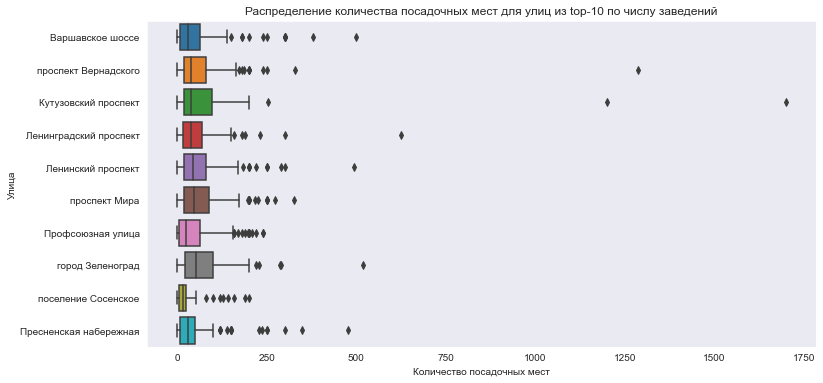

In [34]:
top_10 = top_street.reset_index()['street_name'].tolist()  # создали список улиц из top-10

sns.set_style('dark')
plt.figure(figsize=(12, 6))

sns.boxplot(
    x = 'number', 
    y = 'street_name', 
    data = rest_data.query('street_name in @top_10')
)

plt.title('Распределение количества посадочных мест для улиц из top-10 по числу заведений') 
plt.xlabel('Количество посадочных мест')
plt.ylabel('Улица')
plt.show()




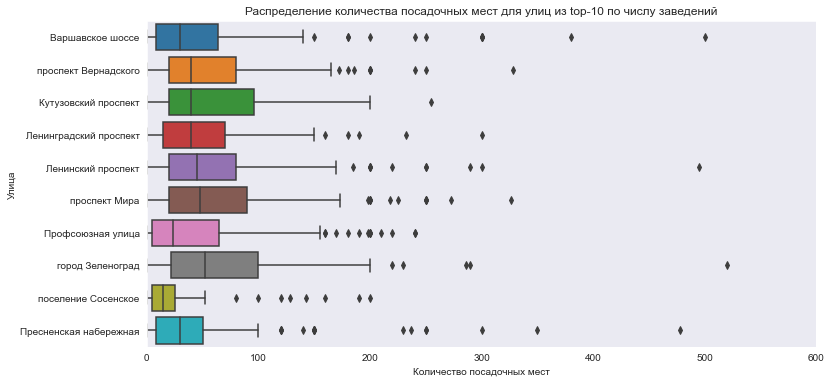

In [35]:

plt.figure(figsize=(12, 6))

sns.boxplot(
    x = 'number', 
    y = 'street_name', 
    data = rest_data.query('street_name in @top_10')
)
plt.xlim([0, 600])  # Ограничили диапазон значений по оси Х
plt.title('Распределение количества посадочных мест для улиц из top-10 по числу заведений') 
plt.xlabel('Количество посадочных мест')
plt.ylabel('Улица')
plt.show()

Выводы по графику. 
- Самые выбивающиеся из общего ряда значения с очень большим количеством посадочных мест (более тысячи) на проспекте Вернадского и на Кутузовском проспекте.
- Самое высокое медианное значение в городе Зеленоград, там же наиболее высокие значения первого и третьего квартилей - то есть большая часть заведений общественного питания имеют довольно много посадочных мест, а не одно-два.
- Наименьшие показатели в поселении Сосновка, что не сложно объяснить тем, что это не очень большой и не популярный микрорайон.
- В целом количество просадочных мест не превышает сотни, максимальные значения менее 200 (не считая выбросов).


## Общие выводы

- Больше всего кафе, затем идут столовые, рестораны и предприятия быстрого обслуживания;
- Самые малочисленные - это магазины (отделы кулинарии), закусочные, кафетерии, чуть больше буфетов и баров.
- Самая большая доля сетевых заведений среди кафе, предприятий быстрого обслуживания и ресторанов.
- Столовые и буфеты сетевыми практически не бывают.
- У сетевых заведений чем больше объем сети, тем меньше в ней в среднем посадочных мест, при этом большинство сетей имеют 2-3 заведения в своем составе. 
- Большим заведением можно считать то, в котором больше 80 мест.
- Самое большое количество посадочных мест предоставляется столовыми, затем ресторанами. 
- Наименьшее число посадочных мест у отделов кулинарии, закусочных и кафетериев.
- Топ-10 улиц с наибольшим числом заведений общепита - это в основном крупные радиальные проспекты, идущие от Садового кольца до МКАД или дальше. Исключение из этого правила составляет Пресненская набережная, возле которой расположен ММДЦ «Москва-Сити».


Итак. На основе статистических данных о имеющихся заведениях общественного питания в городе Москва наиболее часто встречающимися видами являются кафе, рестораны и предприятия быстрого обслуживания с количеством посадочных мест не более 80, находящиеся на крупных транспортных магистралях Москвы в пределах МКАД, с соотношением сетевых и не сетевых как 1:3 или 1:2.

**Общие рекомендации** могут выглядеть следующим образом: открытие небольшого не сетевого кафе с роботами-официантами в пределах МКАД в местах с большим количеством потенциальных покупателей выглядит беспроигрышным.


## Презентация
Подготовлена презентация исследования для инвесторов.

Ссылка на презентацию: https://disk.yandex.ru/d/xjK6freNZuJcDg

